# Attention mechanisms

## Dataset

We will use a dataset from <https://github.com/Charlie9/enron_intent_dataset_verified?tab=readme-ov-file>. This dataset consists of sentences from emails sent between employees of the Enron corporation. Each sentence has been manually labeled regarding whether it contains a request or does not contain a request. We will train an attention model to classify sentences as "request" or "no request" sentences.

In [1]:
def read_intent_file(file_path: str) -> list[str]:
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

# Read positive and negative intent files
pos_intent_path = "data/Enron/intent_pos"
neg_intent_path = "data/Enron/intent_neg"

pos_intent_sentences = read_intent_file(pos_intent_path)
neg_intent_sentences = read_intent_file(neg_intent_path)

## Tokenization

We need to parse the sentences

In [2]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')
tokens = tokenizer("Please send me the report by EOD.")
tokens


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/keesbenkendorfer/miniconda3/envs/ErUM-2/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/keesbenkendorfer/miniconda3/envs/ErUM-2/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/keesbenkendorfer/miniconda3/envs/ErUM-2/lib/python3.11/site-packages/ipykernel/kernel

['please', 'send', 'me', 'the', 'report', 'by', 'eod', '.']

In [3]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for txt in data_iter:
        yield tokenizer(txt)

all_sentences = pos_intent_sentences + neg_intent_sentences

vocab = build_vocab_from_iterator(yield_tokens(all_sentences), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

def encode_batch(batch):
    # batch: list of (raw_sentence, label)
    token_ids = [torch.tensor(vocab(tokenizer(txt)), dtype=torch.long)
                 for txt, _ in batch]
    padded = pad_sequence(token_ids, batch_first=True,
                          padding_value=vocab['<pad>'])
    labels = torch.tensor([lbl for _, lbl in batch], dtype=torch.long)
    return padded, labels

In [24]:
from attention import EnronRequestDataset
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    token_ids_list, labels = zip(*batch)
    # pad to batch max‐len
    src = pad_sequence(token_ids_list,
                       batch_first=True,
                       padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.long)
    # pad_mask: True for PAD tokens, False for real tokens
    pad_mask = src == vocab['<pad>']
    return src, labels, pad_mask

# — now wrap in DataLoader —
sentences = pos_intent_sentences + neg_intent_sentences
labels = [1] * len(pos_intent_sentences) + [0] * len(neg_intent_sentences)

dataset = EnronRequestDataset(sentences, labels, vocab, tokenizer)
loader  = DataLoader(dataset,
                     batch_size=32,
                     shuffle=True,
                     collate_fn=collate_fn,
                     num_workers=0,
                     pin_memory=True)


In [94]:
# import reload
import importlib
import attention
importlib.reload(attention)

import torch.nn as nn

model = attention.RequestClassifier(len(vocab))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

epochs = 50

for epoch in range(epochs):
    for src, labels, pad_mask in loader:
        logits = model(src, src_key_padding_mask=pad_mask)
        loss   = loss_fn(logits, labels)

        if torch.isnan(logits).any():
            print("🛑 NaN in logits!"); break

        loss.backward()
        opt.step(); opt.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/50, Loss: 0.3684
Epoch 2/50, Loss: 0.6398
Epoch 3/50, Loss: 0.6193
Epoch 4/50, Loss: 0.9326
Epoch 5/50, Loss: 0.4454
Epoch 6/50, Loss: 0.4574
Epoch 7/50, Loss: 0.1973
Epoch 8/50, Loss: 0.4650
Epoch 9/50, Loss: 0.3982
Epoch 10/50, Loss: 0.1464
Epoch 11/50, Loss: 0.0348
Epoch 12/50, Loss: 0.1561
Epoch 13/50, Loss: 0.0329
Epoch 14/50, Loss: 0.3237
Epoch 15/50, Loss: 0.1371
Epoch 16/50, Loss: 0.0135
Epoch 17/50, Loss: 0.1120
Epoch 18/50, Loss: 0.0365
Epoch 19/50, Loss: 0.0155
Epoch 20/50, Loss: 0.0095
Epoch 21/50, Loss: 0.0107
Epoch 22/50, Loss: 0.1000
Epoch 23/50, Loss: 0.0035
Epoch 24/50, Loss: 0.0220
Epoch 25/50, Loss: 0.0033
Epoch 26/50, Loss: 0.0332
Epoch 27/50, Loss: 0.0001
Epoch 28/50, Loss: 0.0150
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0008
Epoch 31/50, Loss: 0.0000
Epoch 32/50, Loss: 0.0002
Epoch 33/50, Loss: 0.0001
Epoch 34/50, Loss: 0.0392
Epoch 35/50, Loss: 0.3250
Epoch 36/50, Loss: 0.0001
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.

## Evaluation

In [95]:
# Evaluate single sentence
import torch
import torch.nn.functional as F

def predict_sentence(model, sentence, vocab, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # 1) tokenize & numericalize
        tokens = tokenizer(sentence)
        ids    = torch.tensor(vocab(tokens), dtype=torch.long).unsqueeze(0).to(device)
        # 2) build padding mask (True==pad for Transformer)
        pad_idx = vocab['<pad>']
        mask    = ids != pad_idx
        # 3) forward
        logits = model(ids, src_key_padding_mask=~mask)
        probs  = F.softmax(logits, dim=-1)
        pred   = probs.argmax(dim=-1).item()
    return pred, probs.squeeze().cpu().tolist()

# — Example usage —
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
model     = model.to(device)            # your trained RequestClassifier

test_sentences = [
    "Please send me the report by EOD.",
    "I need the report ASAP.",
    "Can you send me the report?",
    "You used to have a white cat.",
    "The weather is nice today.",
    "Knut is giving a lecture.",
    "Knut, please give the lecture.",
    "This is a test",
    "Cats are blue. I want something blue. Get me a blue cat.",
    "I am requesting a book.",
    "I am requesting a book, please.",
    "Please, I am requesting a book.",
    "Please, please, I am requesting a book.",
]

for sentence in test_sentences:
    pred, probs = predict_sentence(model, sentence, vocab, tokenizer, device)

    label_map = {0: "no_request", 1: "request"}
    print(f"→ {sentence!r}")
    print(f"Prediction: {label_map[pred]} (P(request)={probs[1]:.4f})")


→ 'Please send me the report by EOD.'
Prediction: request (P(request)=1.0000)
→ 'I need the report ASAP.'
Prediction: request (P(request)=1.0000)
→ 'Can you send me the report?'
Prediction: request (P(request)=1.0000)
→ 'You used to have a white cat.'
Prediction: no_request (P(request)=0.0000)
→ 'The weather is nice today.'
Prediction: no_request (P(request)=0.0000)
→ 'Knut is giving a lecture.'
Prediction: request (P(request)=0.9892)
→ 'Knut, please give the lecture.'
Prediction: request (P(request)=0.9999)
→ 'This is a test'
Prediction: no_request (P(request)=0.0021)
→ 'Cats are blue. I want something blue. Get me a blue cat.'
Prediction: request (P(request)=1.0000)
→ 'I am requesting a book.'
Prediction: no_request (P(request)=0.0000)
→ 'I am requesting a book, please.'
Prediction: no_request (P(request)=0.0855)
→ 'Please, I am requesting a book.'
Prediction: no_request (P(request)=0.0855)
→ 'Please, please, I am requesting a book.'
Prediction: no_request (P(request)=0.0015)


## Visualization

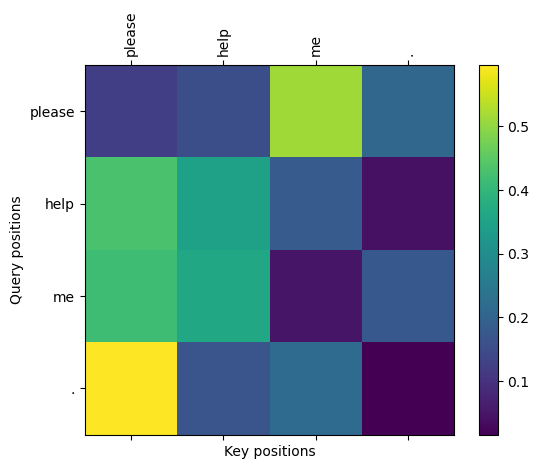

Top tokens by attention paid to them:
      please → 1.564
        help → 1.033
          me → 0.963
           . → 0.440


In [96]:
import matplotlib.pyplot as plt
import numpy as np

import utility
importlib.reload(utility)

def plot_attention(tokens, attn: np.ndarray):
    # tokens: List[str], attn: [S,S] NumPy array
    fig, ax = plt.subplots()
    cax = ax.matshow(attn)             # one distinct plot, no seaborn
    fig.colorbar(cax)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    plt.xlabel("Key positions"); plt.ylabel("Query positions")
    plt.show()


text = "Please help me."
tokens = tokenizer(text)
ids    = torch.tensor([vocab(tokens)], dtype=torch.long)
padm   = ids == vocab['<pad>']

model.eval()
with torch.no_grad():
    logits, attn = model(ids, src_key_padding_mask=padm, return_attn=True)
    # attn: [1, seq_len, seq_len]  (since single head)

    attn_np = np.asarray(attn[0].detach().cpu().tolist())

plot_attention(tokens, attn_np)

col_importance = [ sum(row[j] for row in attn_np) for j in range(len(tokens)) ]

# pair and sort
token_scores = zip(tokens, col_importance)

print("Top tokens by attention paid to them:")
for token, score in token_scores:
    print(f"  {token:>10} → {score:.3f}")

utility.display_tokens_with_alpha(tokens, col_importance)


Now let's plot a number of sentences, and see which words are most important.

In [105]:
test_sentences = [
    "Please send me the report by EOD.",
    "I need the report ASAP.",
    "Please help me out with the report.",
]

for sentence in test_sentences:
    tokens = tokenizer(sentence)
    ids    = torch.tensor([vocab(tokens)], dtype=torch.long)
    padm   = ids == vocab['<pad>']

    model.eval()
    with torch.no_grad():
        logits, attn = model(ids, src_key_padding_mask=padm, return_attn=True)
        # attn: [1, seq_len, seq_len]  (since single head)

        attn_np = np.asarray(attn[0].detach().cpu().tolist())

    col_importance = [ sum(row[j] for row in attn_np) for j in range(len(tokens)) ]

    utility.display_tokens_with_alpha(tokens, col_importance)
    print(f"Prediction: {label_map[logits.argmax(dim=-1).item()]} ; P(request)={F.softmax(logits, dim=-1)[0][1]:.4f}")
    print("")


Prediction: request ; P(request)=1.0000



Prediction: request ; P(request)=1.0000



Prediction: request ; P(request)=1.0000

